<a href="https://colab.research.google.com/github/tiago121/Sales_prediction_pharmacy_chain/blob/main/Store_sales_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store sales prediction

## 0 Initial considarations

Uma cadeia de farmácias quer modernizar as drogarias da rede, implementando a possibilidade de tele-entrega em 100% delas. No entanto, o custo da operação é elevado e o maior desafio é saber se as lojas terão receita suficiente para realizar a reforma e ainda dar lucro.


A rede conta com informações detalhadas de mais de mil lojas. Algumas delas são: 

1. Número de clientes
2. Feriados
3. Tipo de loja
4. Indicador se participa de promoções
5. Distância até o próximo concorrente


Baseando-se nessas informações é possível criar um modelo que nos dê a previsão de receita para assemanas em cada loja, lidando com cenários pessimists e otimistas. 

In [1]:
!pip install inflection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 0.1 Imports

In [2]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler

warnings.filterwarnings( 'ignore' )

### 0.2 Helper Functions

In [3]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )
    
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )




def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()


In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib





### 0.3 Loading data 


In [5]:

df_sales_raw = pd.read_csv( '/content/drive/MyDrive/Datasets/time series ds produção/rossmann-store-sales/train.csv', low_memory=False)
df_sales_raw = df_sales_raw.rename(columns=str.lower)
df_store_raw = pd.read_csv( '/content/drive/MyDrive/Datasets/time series ds produção/rossmann-store-sales/store.csv', low_memory=False)
df_store_raw = df_store_raw.rename(columns=str.lower)
# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='store' )
df_raw = df_raw.sample(frac =.25)

## 1.0 Data Description


In [6]:
df1 = df_raw.copy()

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254302 entries, 597399 to 364313
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   store                      254302 non-null  int64  
 1   dayofweek                  254302 non-null  int64  
 2   date                       254302 non-null  object 
 3   sales                      254302 non-null  int64  
 4   customers                  254302 non-null  int64  
 5   open                       254302 non-null  int64  
 6   promo                      254302 non-null  int64  
 7   stateholiday               254302 non-null  object 
 8   schoolholiday              254302 non-null  int64  
 9   storetype                  254302 non-null  object 
 10  assortment                 254302 non-null  object 
 11  competitiondistance        253637 non-null  float64
 12  competitionopensincemonth  173373 non-null  float64
 13  competitionopensinceyear

Observações sobre os dados: há dados faltantes em algumas colunas e precisamos fazer transformações nos tipos de dados.

### 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

In [9]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
597399,545,7,2014-01-12,0,0,0,0,0,0,a,c,5020.0,5.0,2006.0,1,18.0,2014.0,"Feb,May,Aug,Nov"
937002,73,3,2013-03-13,4314,504,1,0,0,0,a,c,1650.0,9.0,2008.0,0,NaN,NaN,NaN
905193,599,4,2013-04-11,8646,789,1,1,0,0,d,c,580.0,11.0,2014.0,0,NaN,NaN,NaN
1000557,73,2,2013-01-15,3827,491,1,0,0,0,a,c,1650.0,9.0,2008.0,0,NaN,NaN,NaN
268814,776,4,2014-11-27,5358,552,1,1,0,0,c,a,700.0,4.0,2009.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


### 1.2 Change Data types

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.3 Filling missing values

In [11]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


Algumas transformações feitas:

1. competition_distance: caso não tivesse dados da competição mais próxima, o mais provável é que esteja a uma distância grande. Por isso, todas as lojas com valor desconhecido tiveram o valor máximo de distância registrada, 200 km
2. competition_open_since: foi considerado que, caso não houvesse a data da abertura da concorrência ou de promoções, o valor imputado seria a data das vendas
3. promo_interval: caso não fosse dado o mês dos intervalos, foi imputado o valor 0, sendo que a suposição é de que não haveria promoção consecutiva
4. month_map: o mês da venda
5. is_promo: se no mês da venda teve promoção ou não


In [12]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
597399,545,7,2014-01-12,0,0,0,0,0,0,a,c,5020.0,5.0,2006.0,1,18.0,2014.0,"Feb,May,Aug,Nov",Jan,0
937002,73,3,2013-03-13,4314,504,1,0,0,0,a,c,1650.0,9.0,2008.0,0,11.0,2013.0,0,Mar,0
905193,599,4,2013-04-11,8646,789,1,1,0,0,d,c,580.0,11.0,2014.0,0,15.0,2013.0,0,Apr,0
1000557,73,2,2013-01-15,3827,491,1,0,0,0,a,c,1650.0,9.0,2008.0,0,3.0,2013.0,0,Jan,0
268814,776,4,2014-11-27,5358,552,1,1,0,0,c,a,700.0,4.0,2009.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Nov,0


### 1.4 Change Data Types

In [13]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

### 1.5. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.5.1. Numerical Atributes

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.676778,558.0,322.234238,0.000712,-1.201793
1,day_of_week,1.0,7.0,6.0,3.990295,4.0,1.995510,0.008675,-1.245923
2,sales,0.0,41551.0,41551.0,5779.536791,5743.0,3849.436365,0.655505,1.866042
3,customers,0.0,5192.0,5192.0,633.814138,609.0,465.181288,1.620002,7.202392
4,open,0.0,1.0,1.0,0.831271,1.0,0.374512,-1.769094,1.129703
5,promo,0.0,1.0,1.0,0.381094,0.0,0.485656,0.489674,-1.760233
6,school_holiday,0.0,1.0,1.0,0.180054,0.0,0.384232,1.665390,0.773531
7,competition_distance,20.0,200000.0,199980.0,5927.558611,2330.0,12567.316256,10.257077,147.858208
8,competition_open_since_month,1.0,12.0,11.0,6.785963,7.0,3.306711,-0.041029,-1.231092
9,competition_open_since_year,1900.0,2015.0,115.0,2010.329545,2012.0,5.433048,-6.900564,118.258228


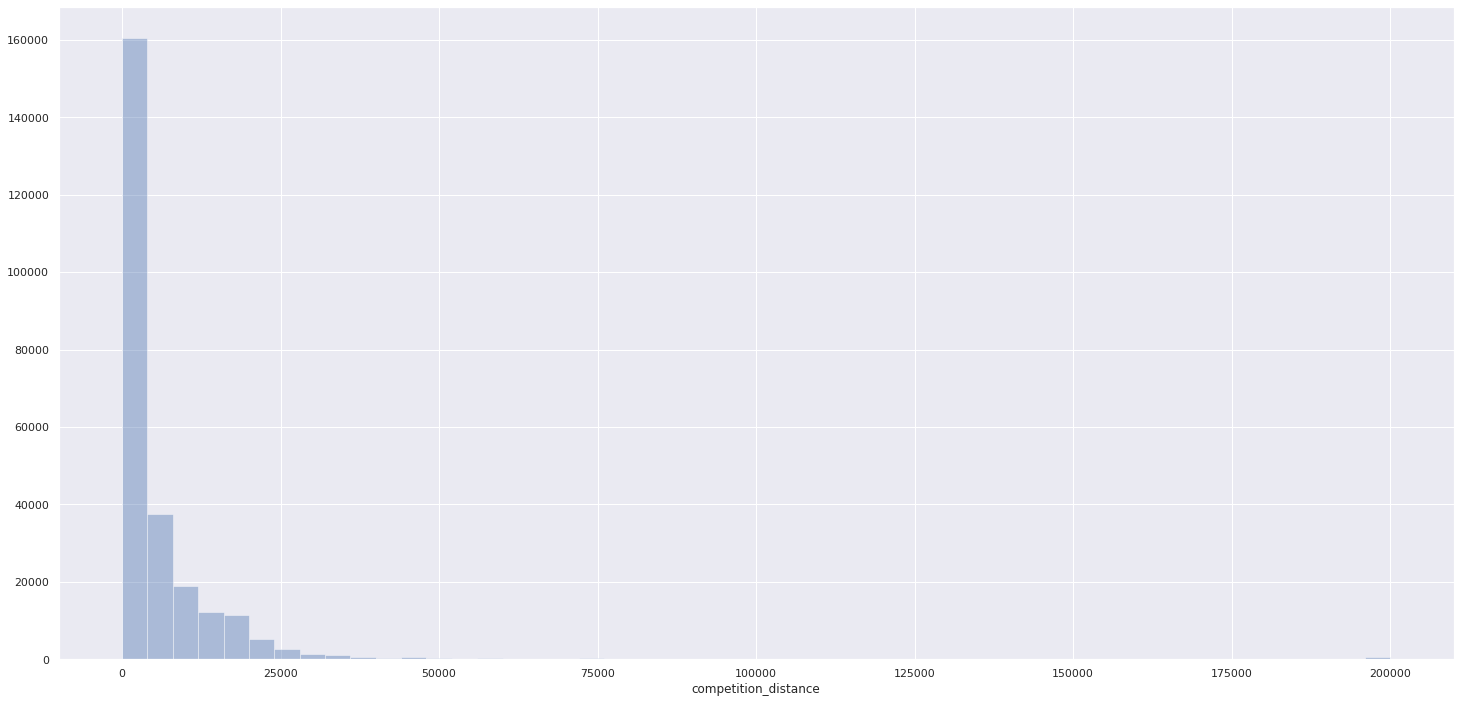

In [16]:
sns.distplot( df1['competition_distance'], kde=False )

#### 1.5.2. Categorical Atributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

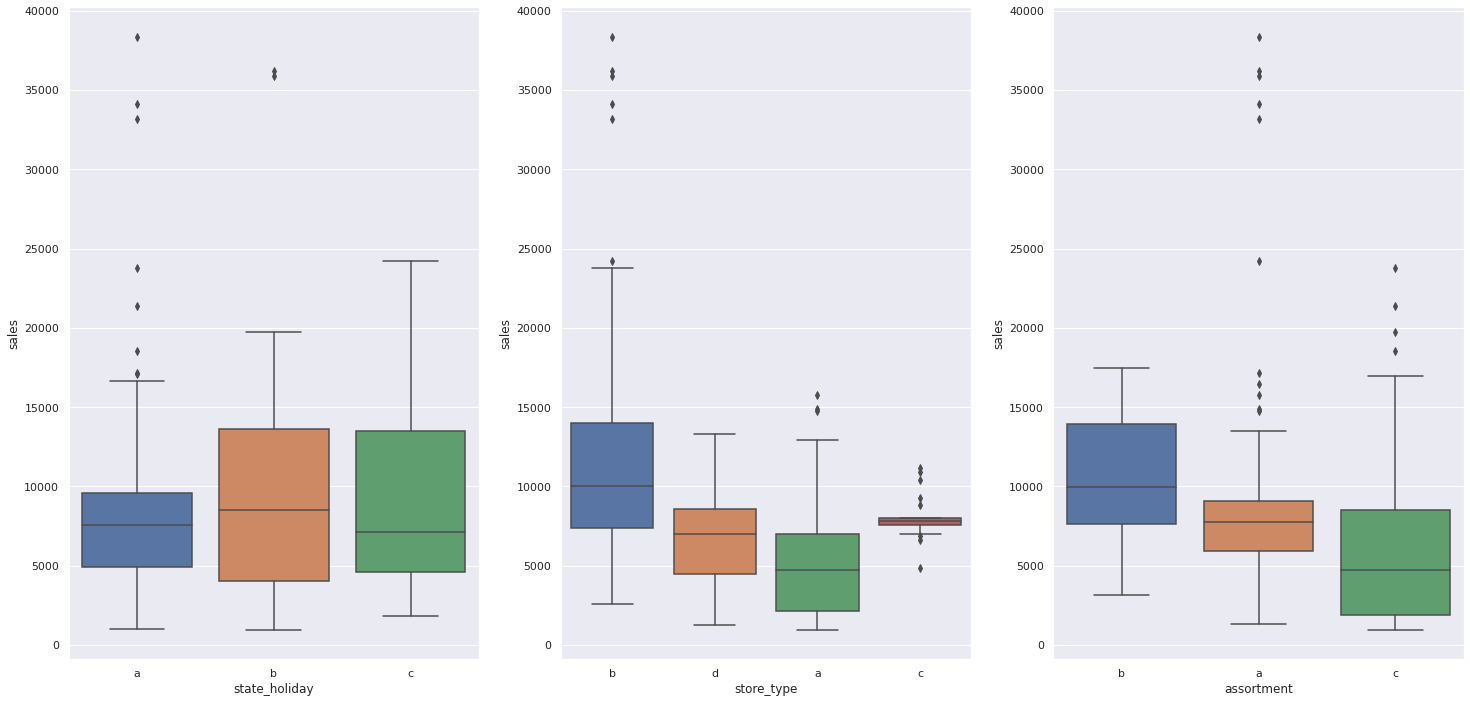

In [18]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

## 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas')

Algumas mudanças importantes:

1. Da data de vendas foram extraindos, em colunas diferentes, o dia, mês, ano e semana do ano
2. Competition_open_since_month e competition_open_since_year foram juntados para criar uma coluna com a data desde a abertura da competição
3. O mesmo foi feito com as promoções, criando uma coluna com a data desde o começo da promoção, assim como os dias de promoção


In [21]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
597399,545,7,2014-01-12,0,0,0,0,christmas,0,a,extended,5020.0,5,2006,1,18,2014,"Feb,May,Aug,Nov",Jan,0,2014,1,12,2,2014-01,2006-05-01,93,2014-04-28,-16
937002,73,3,2013-03-13,4314,504,1,0,christmas,0,a,extended,1650.0,9,2008,0,11,2013,0,Mar,0,2013,3,13,11,2013-10,2008-09-01,55,2013-03-11,0
905193,599,4,2013-04-11,8646,789,1,1,christmas,0,d,extended,580.0,11,2014,0,15,2013,0,Apr,0,2013,4,11,15,2013-14,2014-11-01,-19,2013-04-08,0
1000557,73,2,2013-01-15,3827,491,1,0,christmas,0,a,extended,1650.0,9,2008,0,3,2013,0,Jan,0,2013,1,15,3,2013-02,2008-09-01,53,2013-01-14,0
268814,776,4,2014-11-27,5358,552,1,1,christmas,0,c,basic,700.0,4,2009,1,14,2011,"Jan,Apr,Jul,Oct",Nov,0,2014,11,27,48,2014-47,2009-04-01,68,2011-03-28,191


## 3.0 Data Filtering

In [22]:
df3 = df2.copy()

In [23]:
# Rows
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
# Columns
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [24]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
937002,73,3,2013-03-13,4314,0,christmas,0,a,extended,1650.0,9,2008,0,11,2013,0,2013,3,13,11,2013-10,2008-09-01,55,2013-03-11,0
905193,599,4,2013-04-11,8646,1,christmas,0,d,extended,580.0,11,2014,0,15,2013,0,2013,4,11,15,2013-14,2014-11-01,-19,2013-04-08,0
1000557,73,2,2013-01-15,3827,0,christmas,0,a,extended,1650.0,9,2008,0,3,2013,0,2013,1,15,3,2013-02,2008-09-01,53,2013-01-14,0
268814,776,4,2014-11-27,5358,1,christmas,0,c,basic,700.0,4,2009,1,14,2011,0,2014,11,27,48,2014-47,2009-04-01,68,2011-03-28,191
495346,1072,1,2014-04-14,9706,1,christmas,1,a,extended,5380.0,8,2015,1,5,2010,0,2014,4,14,16,2014-15,2015-08-01,-16,2010-01-25,220


## 4.0 EDA (Exploratoty Data Analysis)

In [25]:
df4 = df3.copy()

###4.1 Univariate analysis

#### 4.1.1 Response Variable

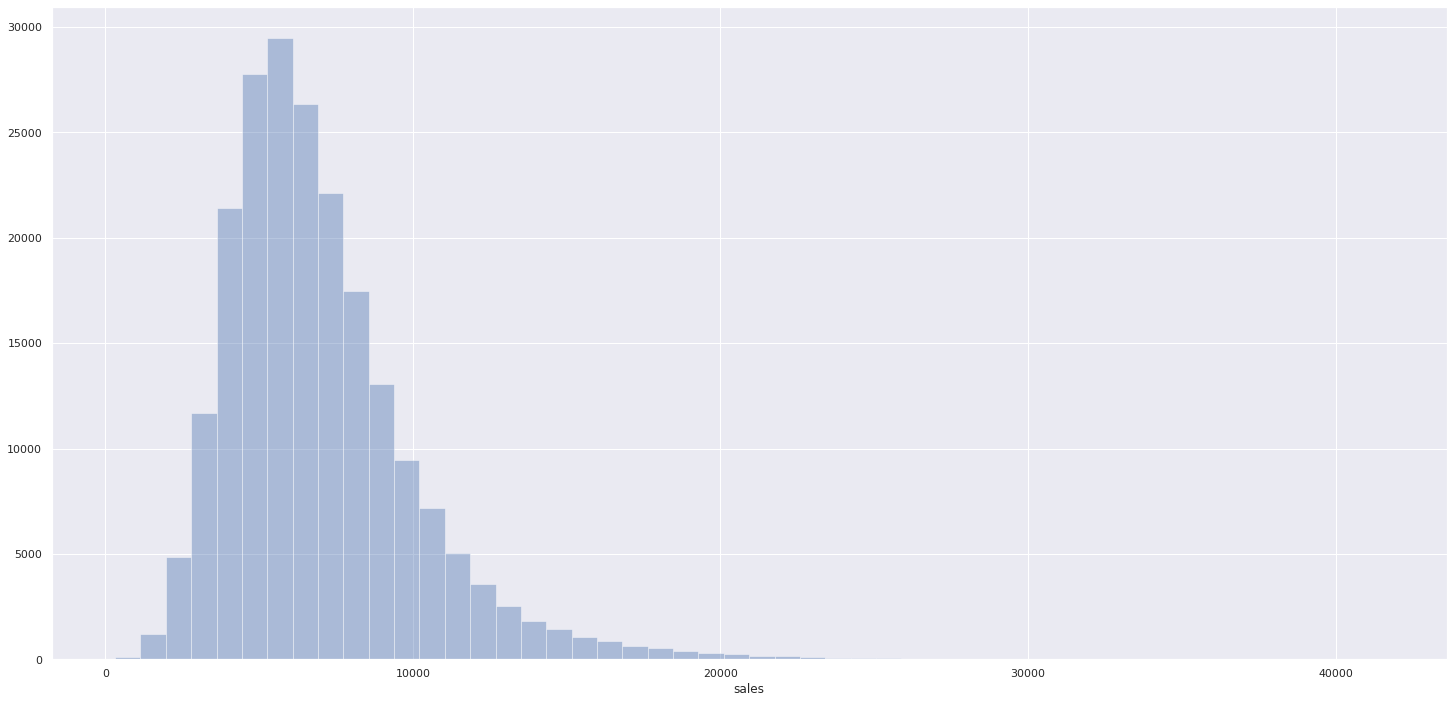

In [26]:
sns.distplot( df4['sales'], kde=False  )

#### 4.1.2 Numerical Variables


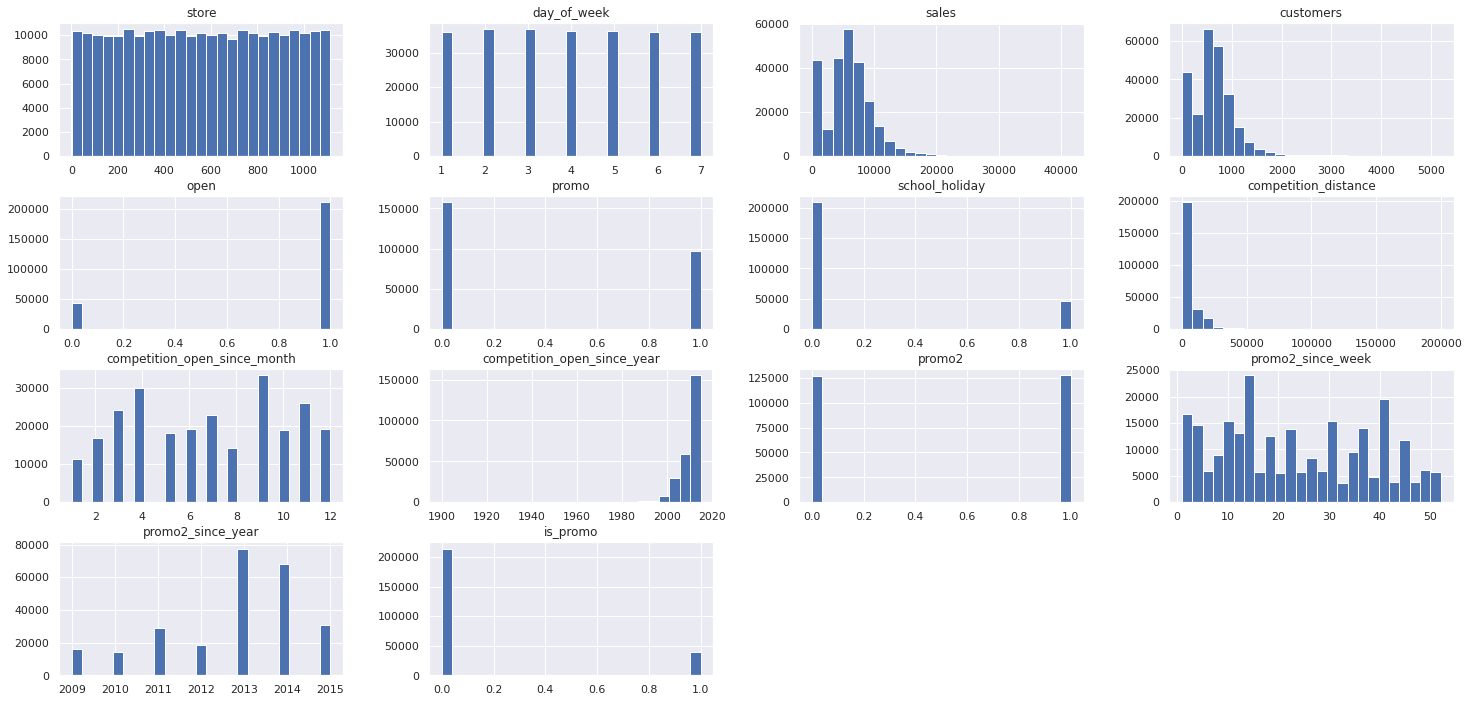

In [27]:
num_attributes.hist( bins=25 );

#### 4.1.3 Categorical Variables

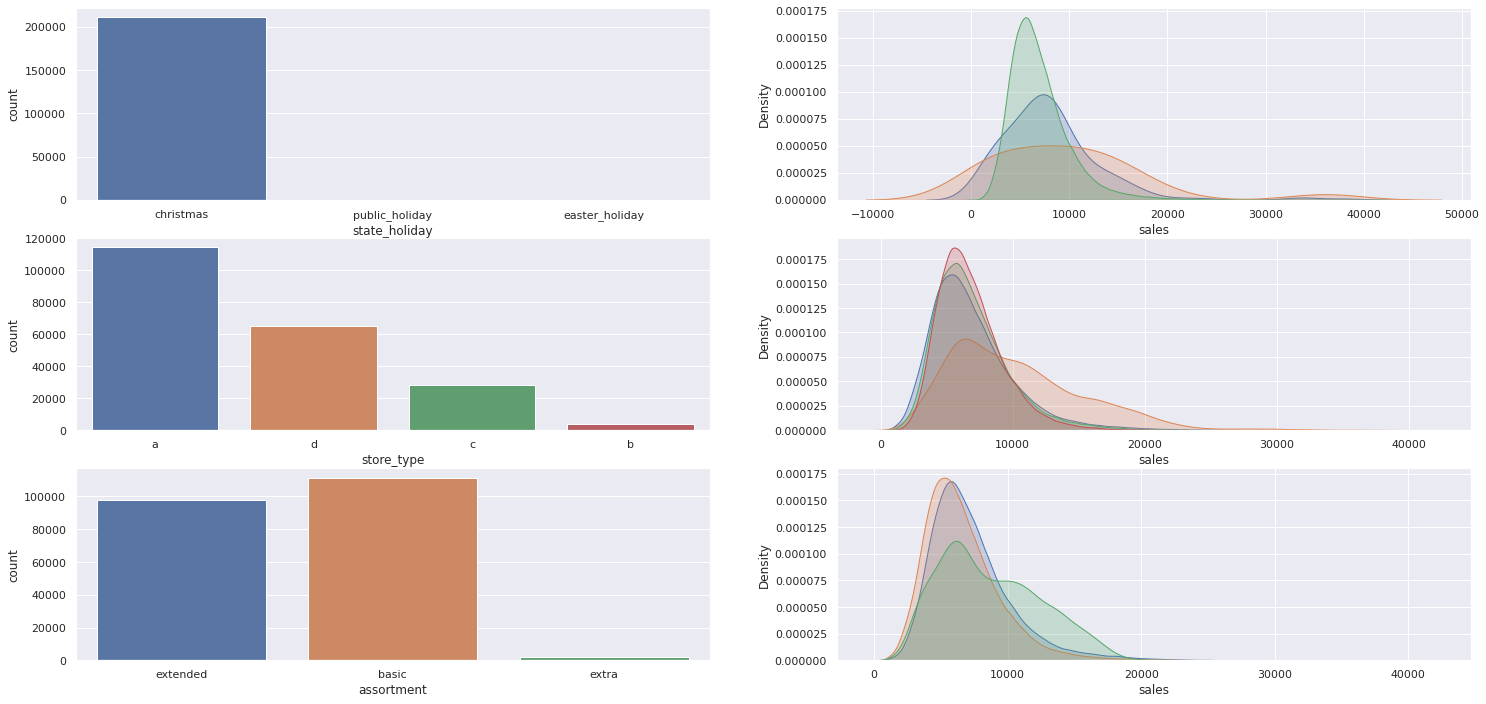

In [28]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

###4.2 Bivariate analysis

####4.2.1 Assortment

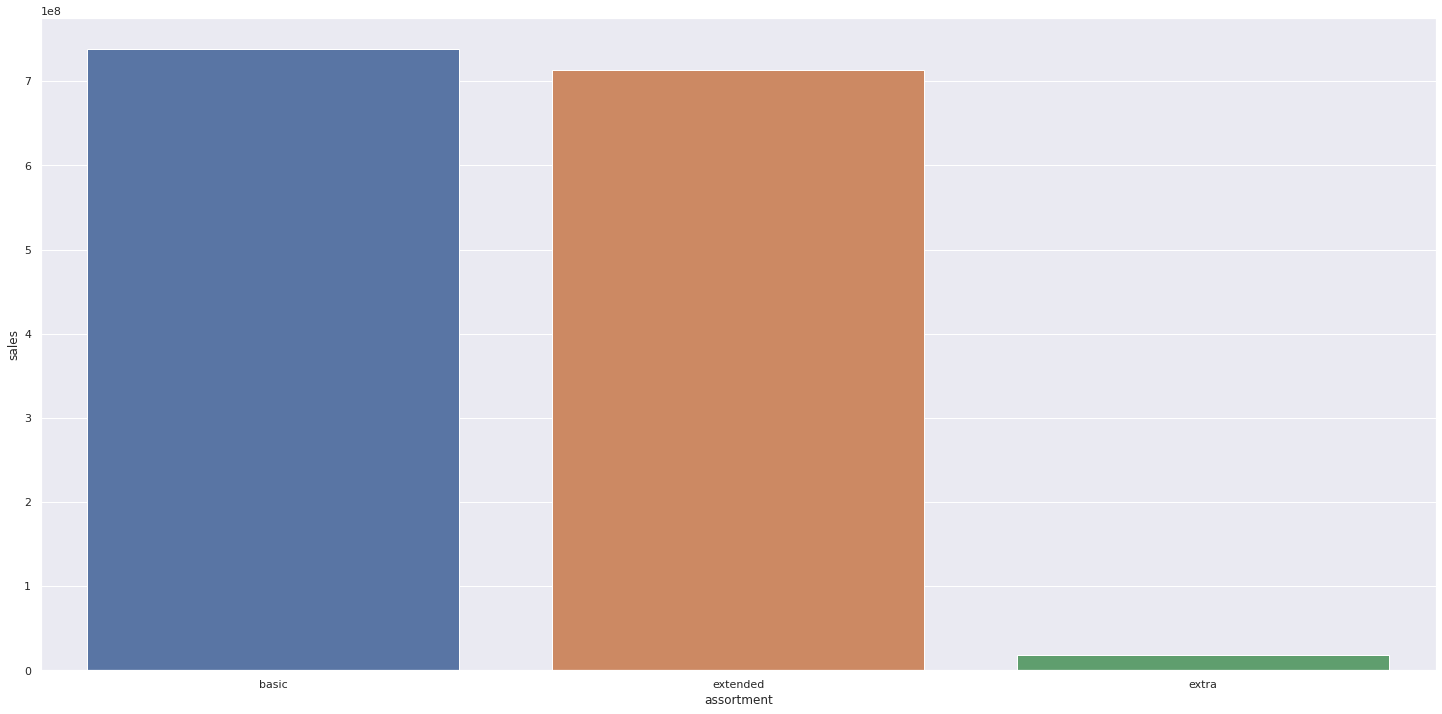

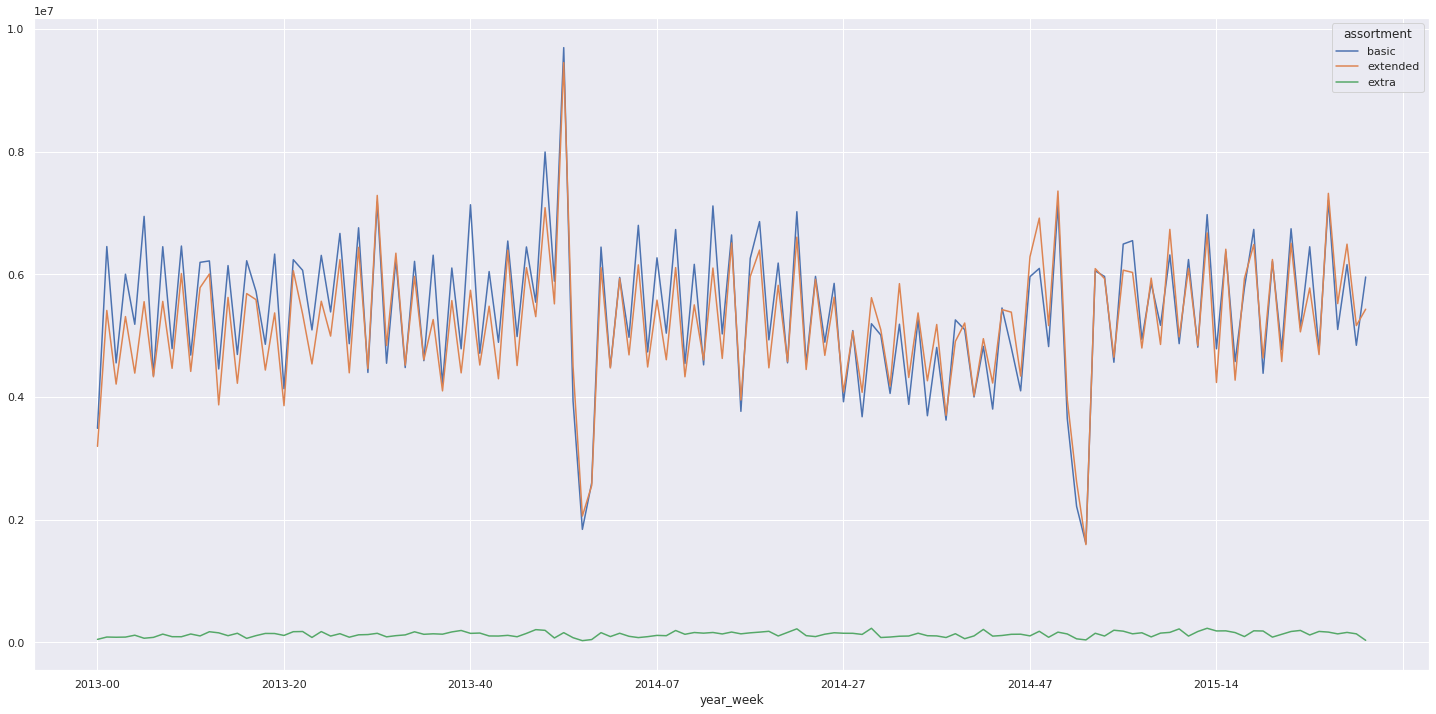

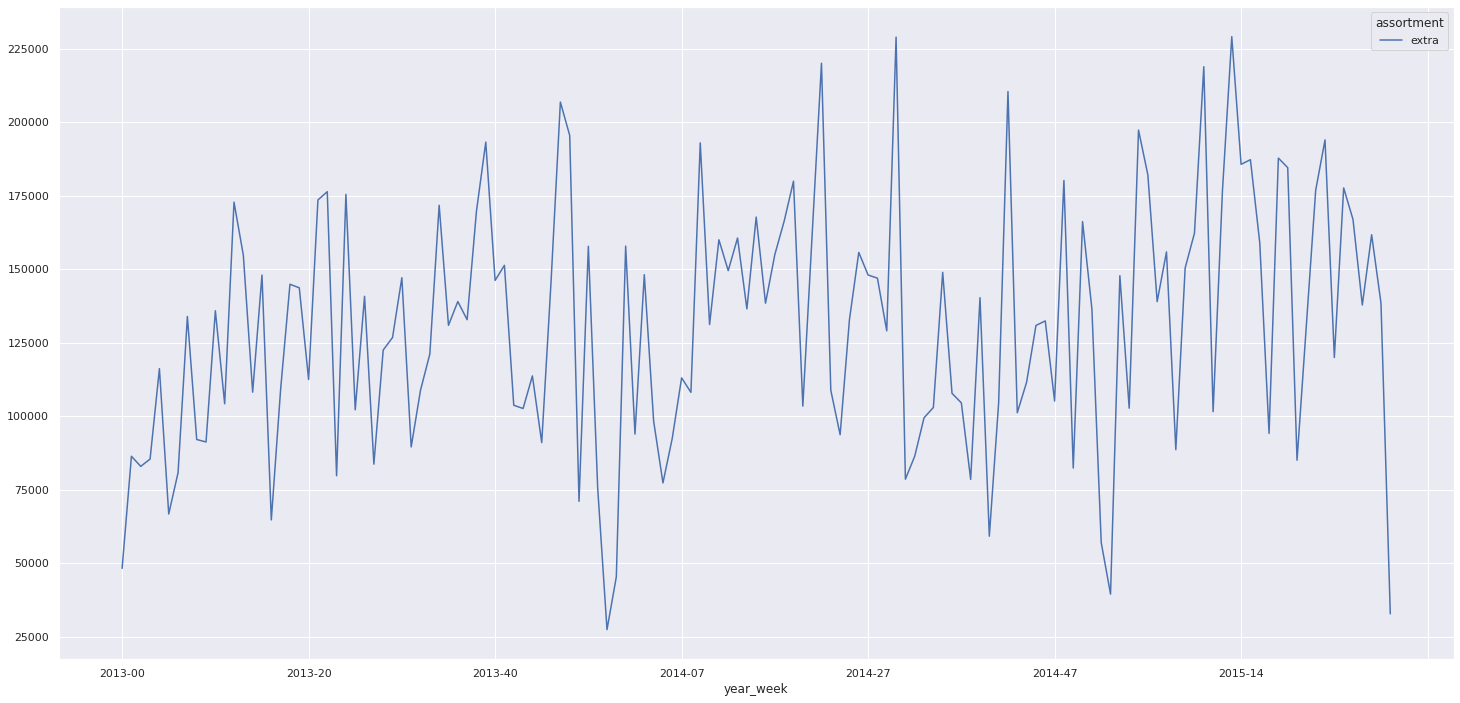

In [29]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

#### 4.2.2 Competition Distance

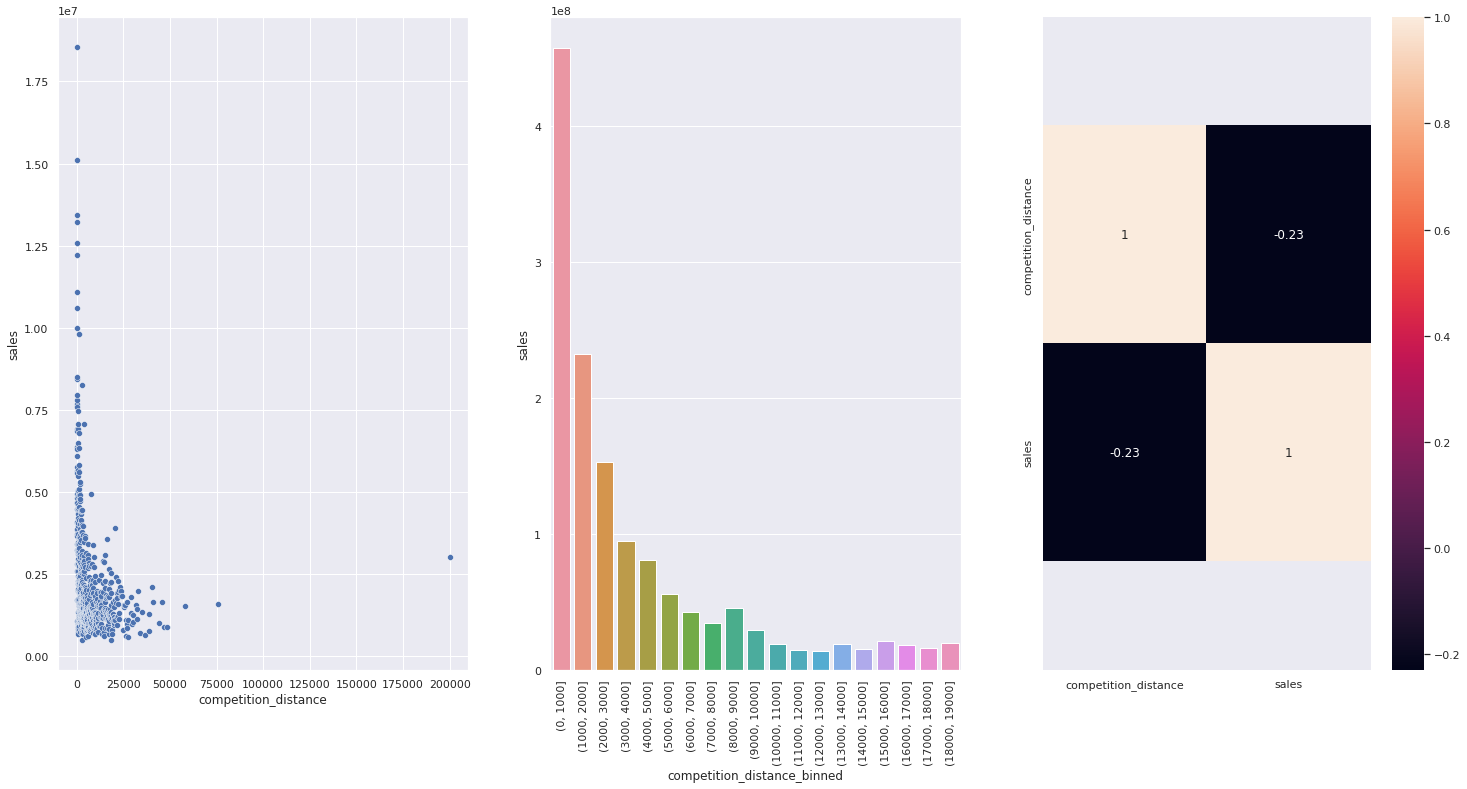

In [30]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

#### 4.2.3 Competition Time Month

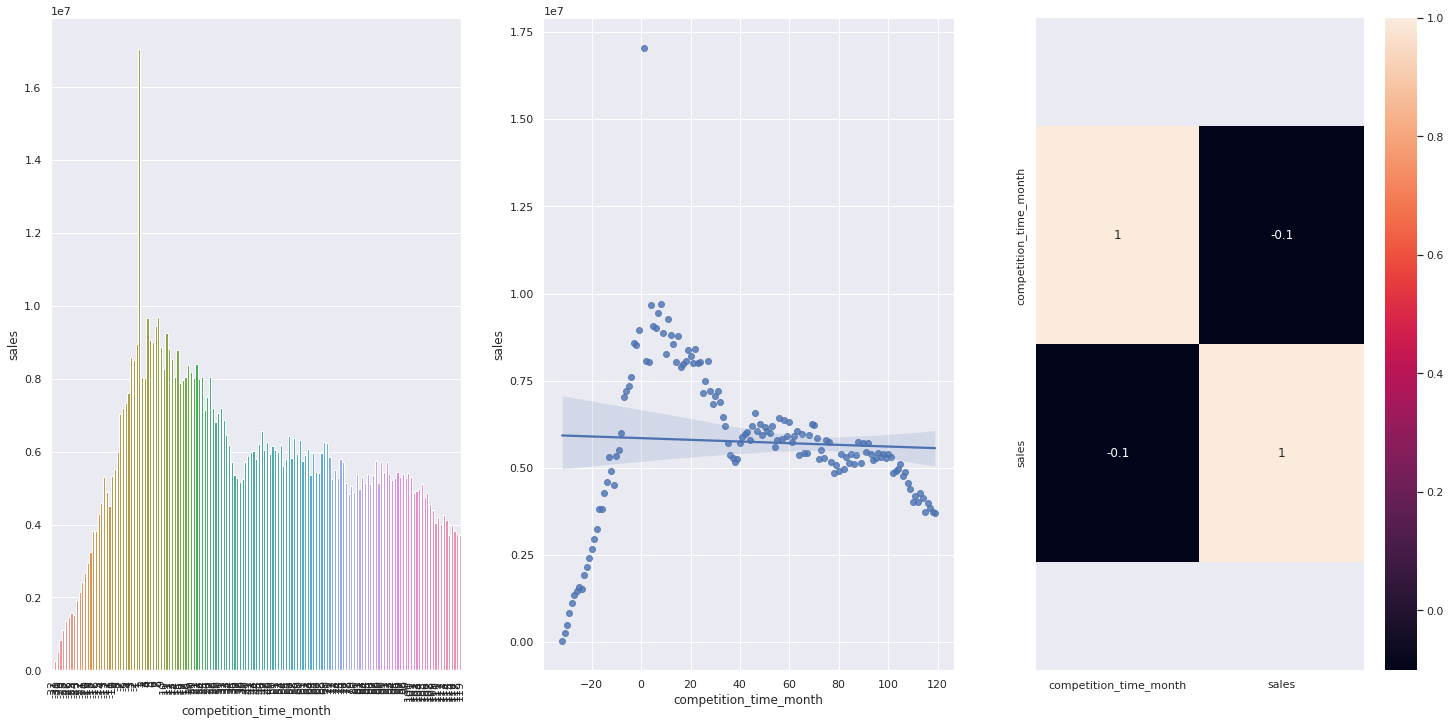

In [31]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

####4.2.4 Promo Time Week

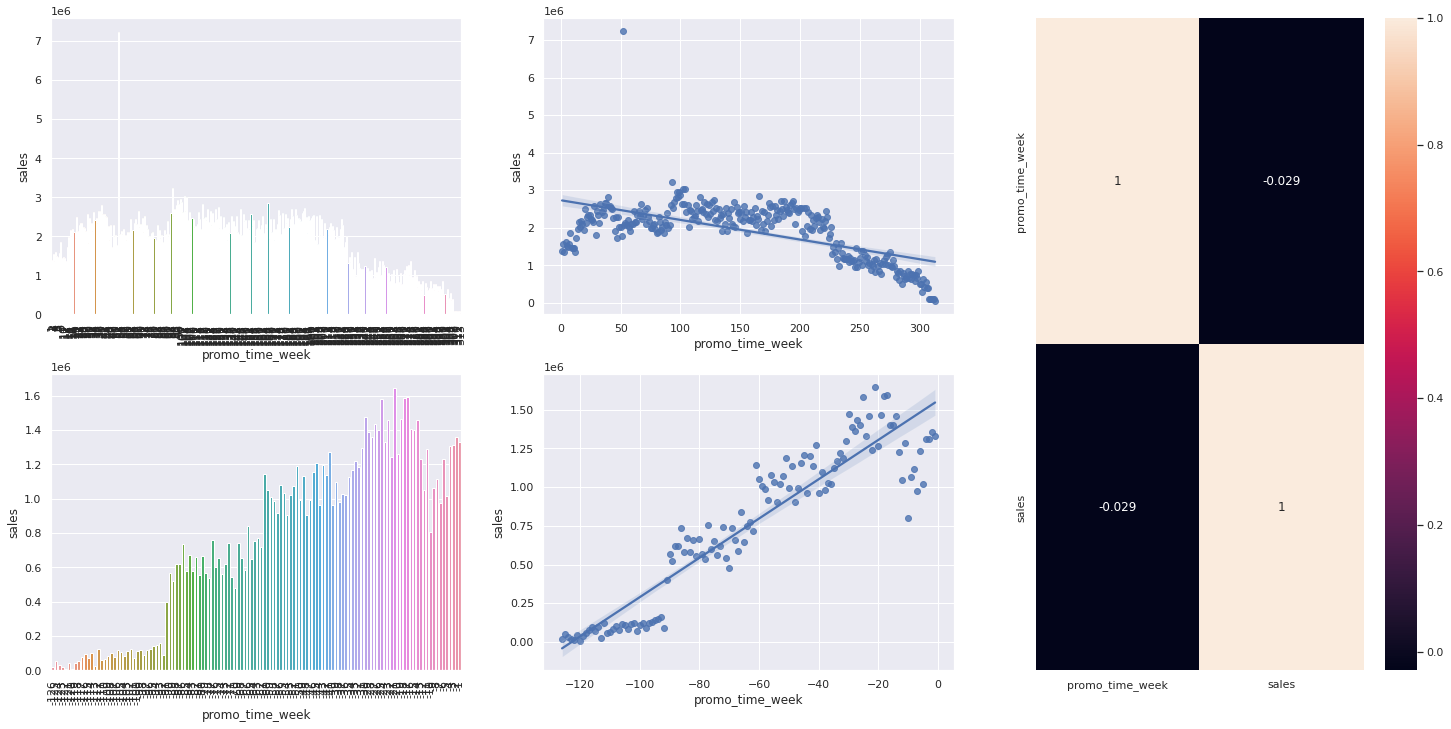

In [32]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### 4.2.5 State Holiday 

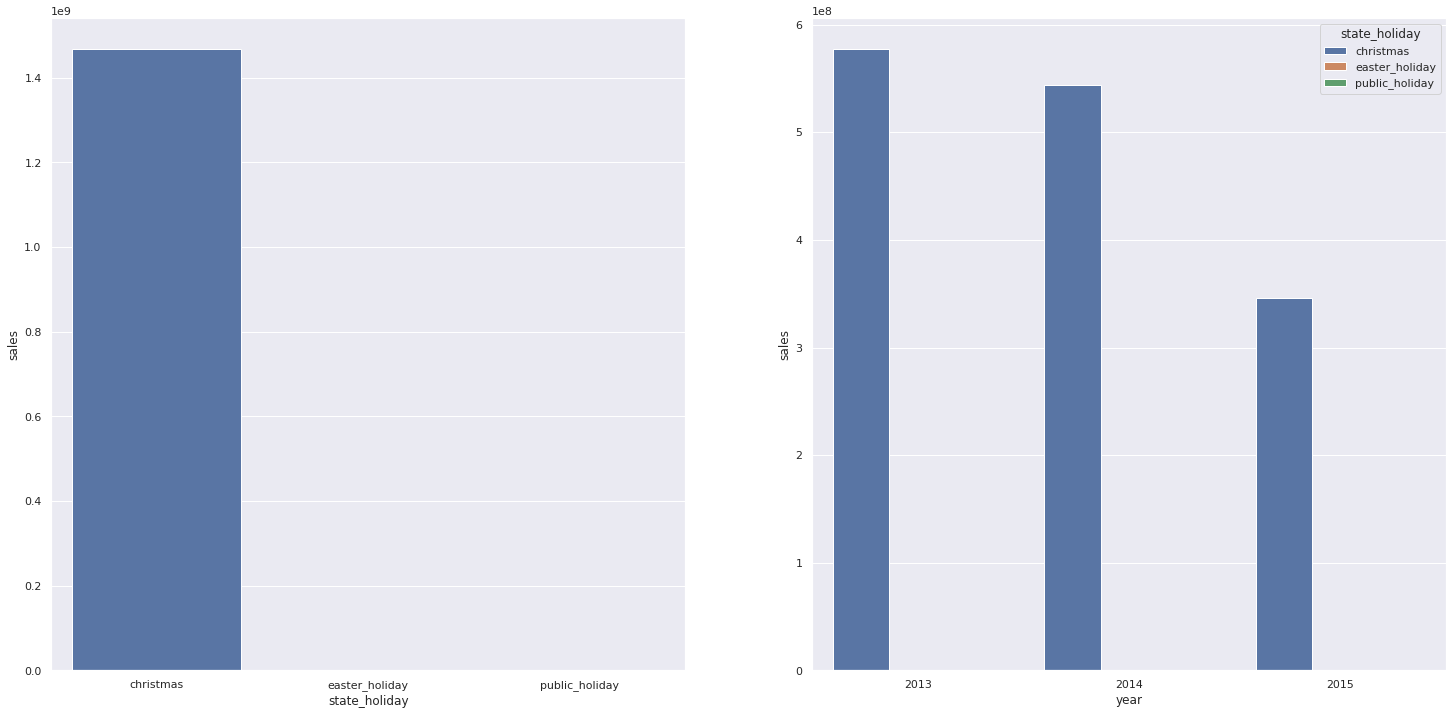

In [33]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### 4.2.6 Year

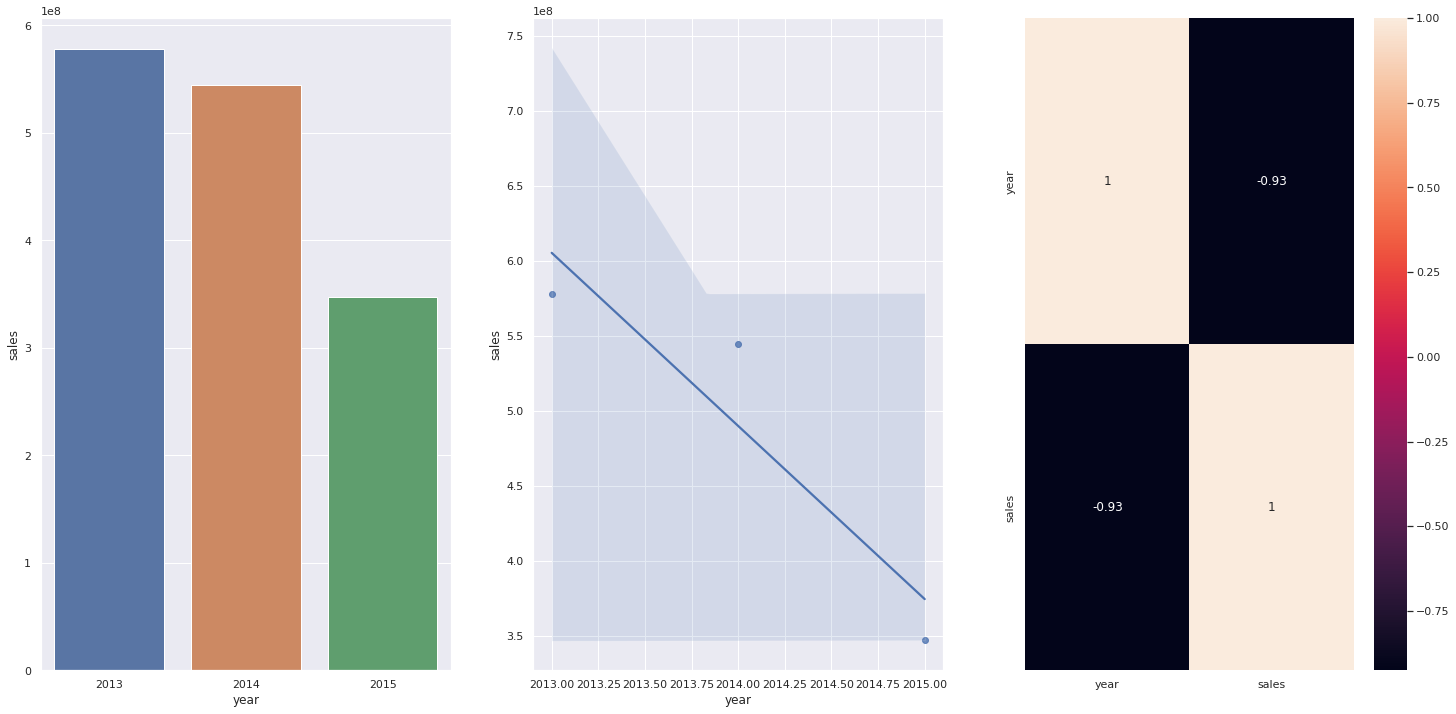

In [34]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

####4.2.7 Mouth

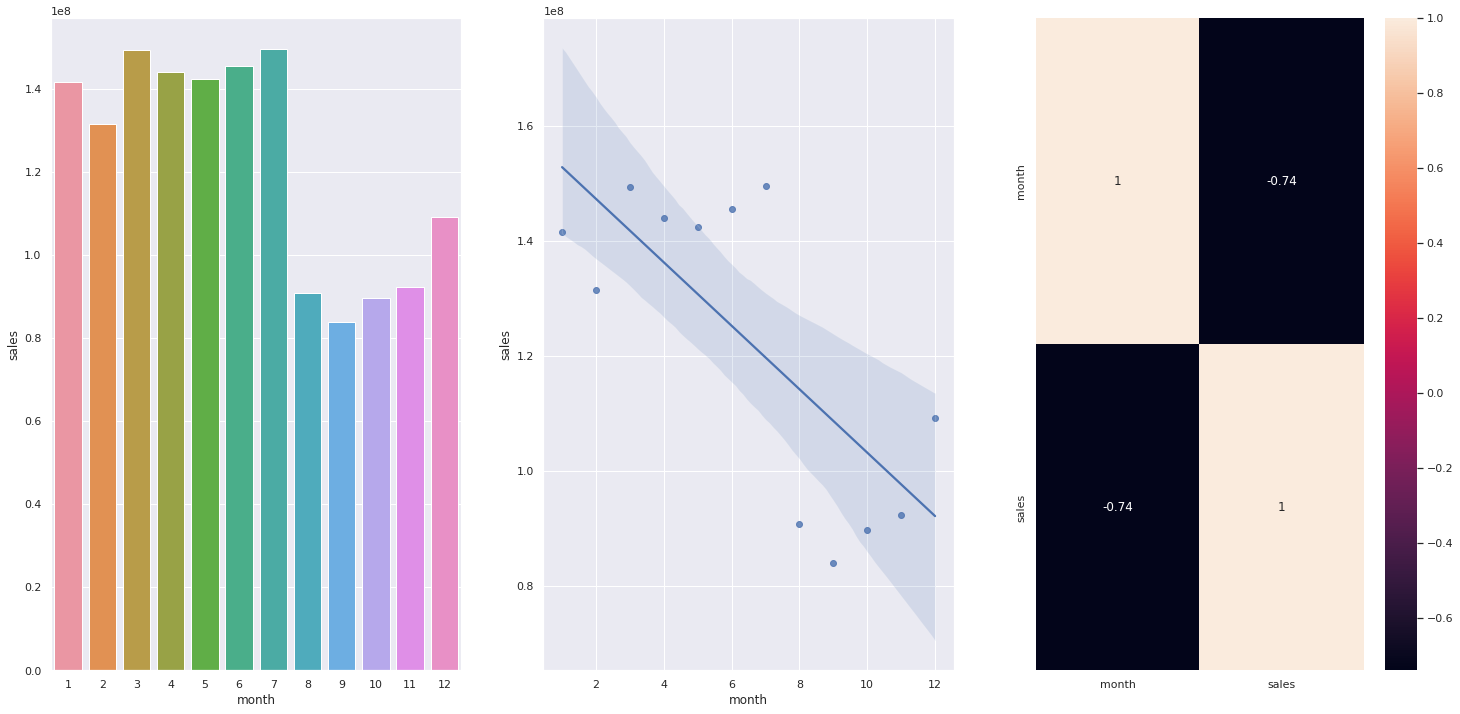

In [35]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

####4.2.8 Day

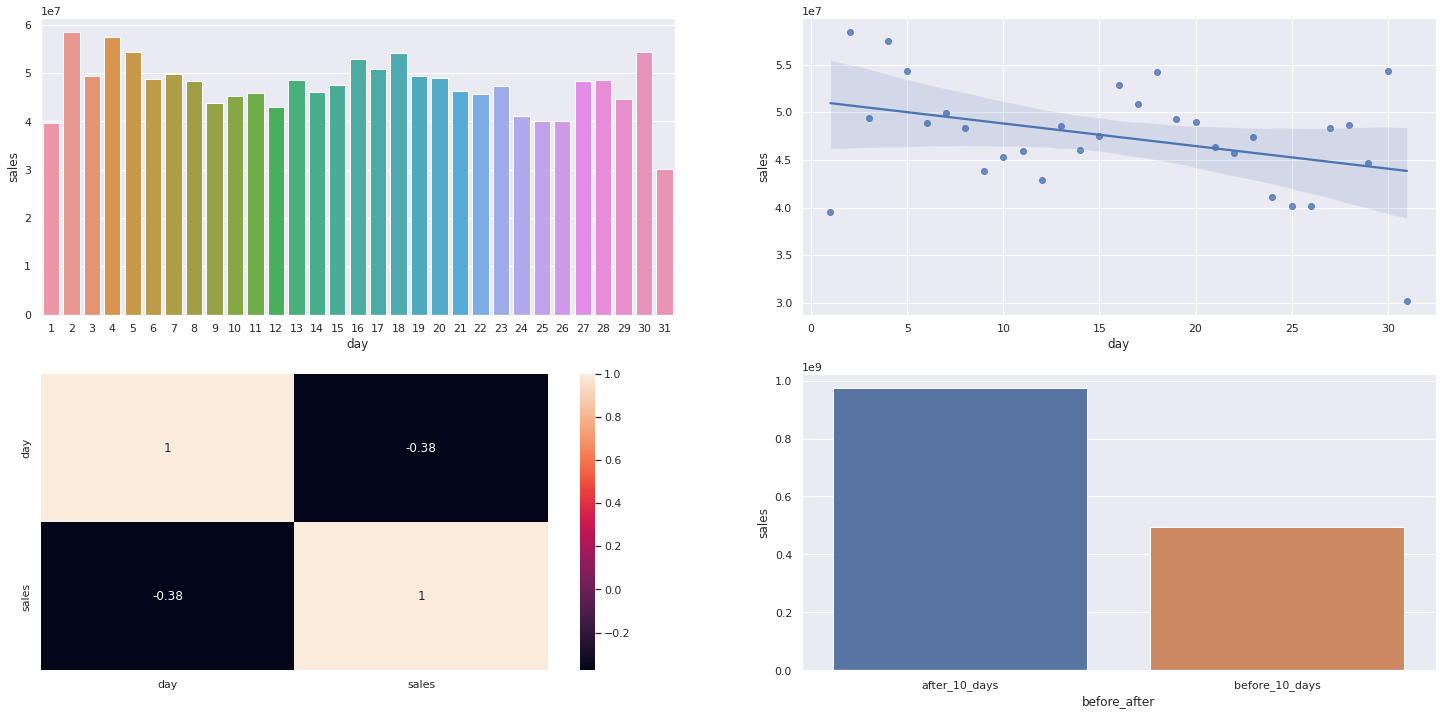

In [36]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

####4.2.9 Day of Week

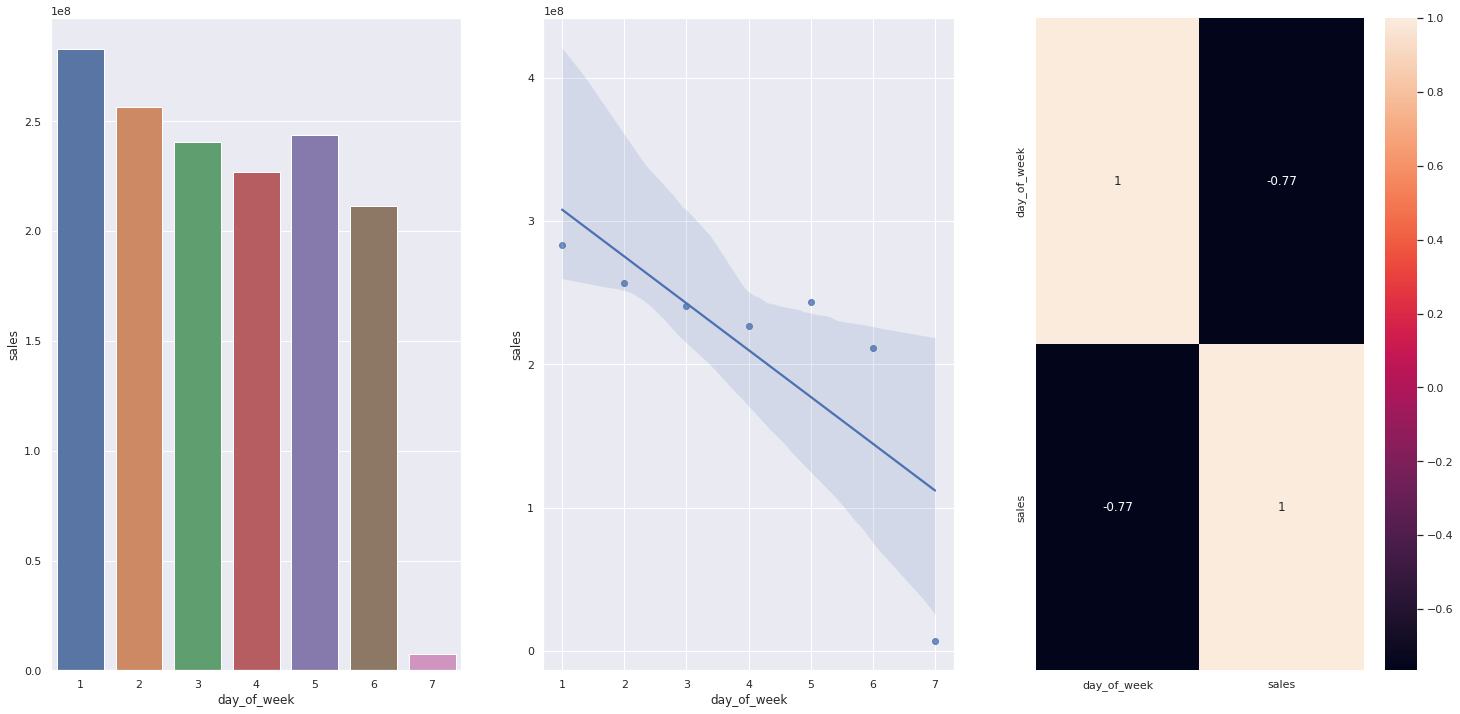

In [37]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### 4.2.10 School Holiday

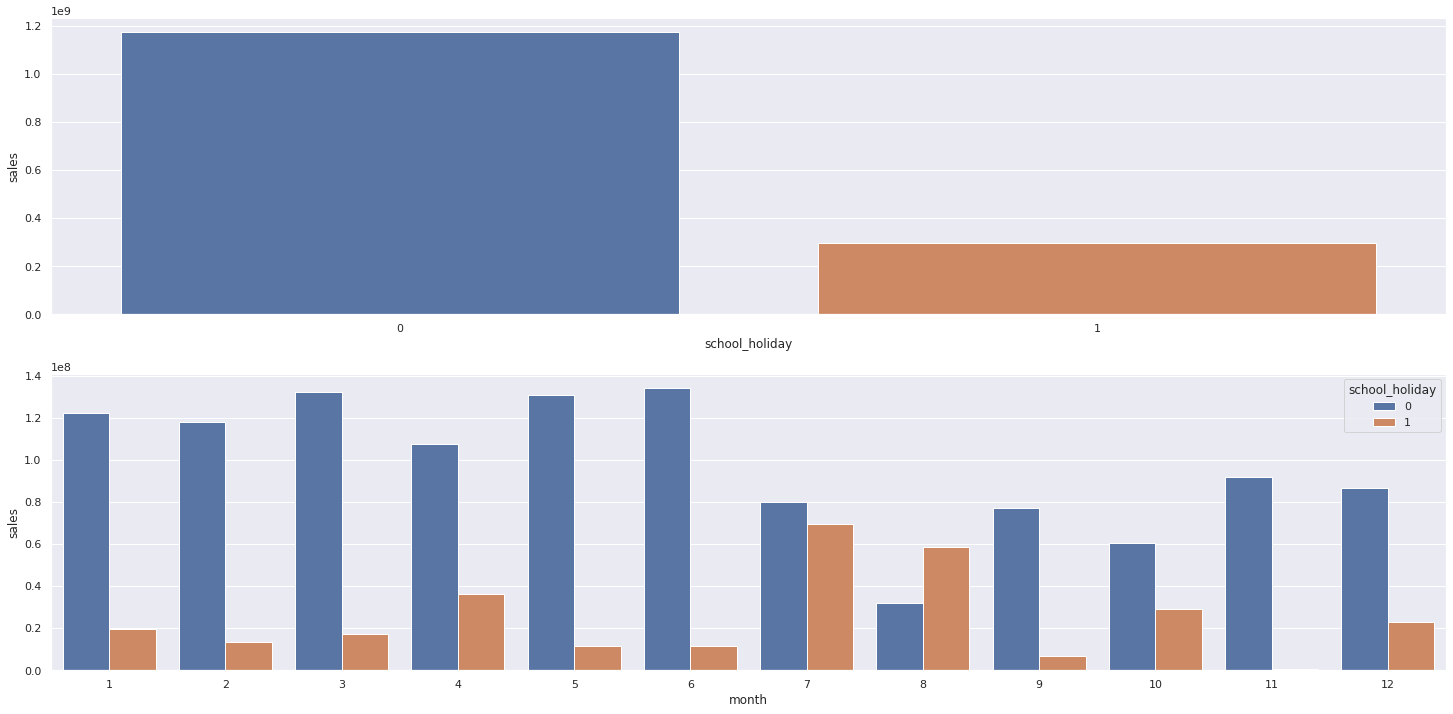

In [38]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

#### 4.2.11 Promo/Promo2

In [39]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,372186008
1,0,1,323564029
2,1,0,407625234
3,1,1,366372494


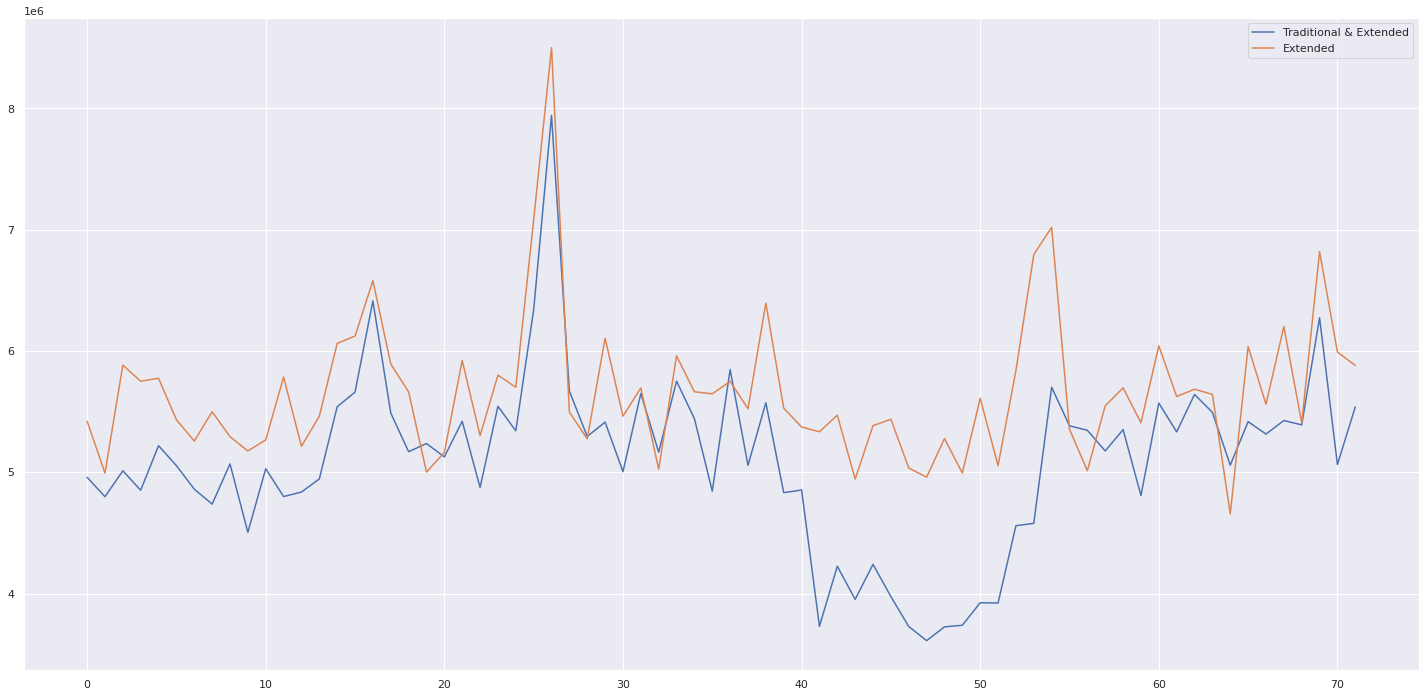

In [40]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Traditional & Extended', 'Extended']);

###4.3 Multivariate analysis

#### Numerical Attributes

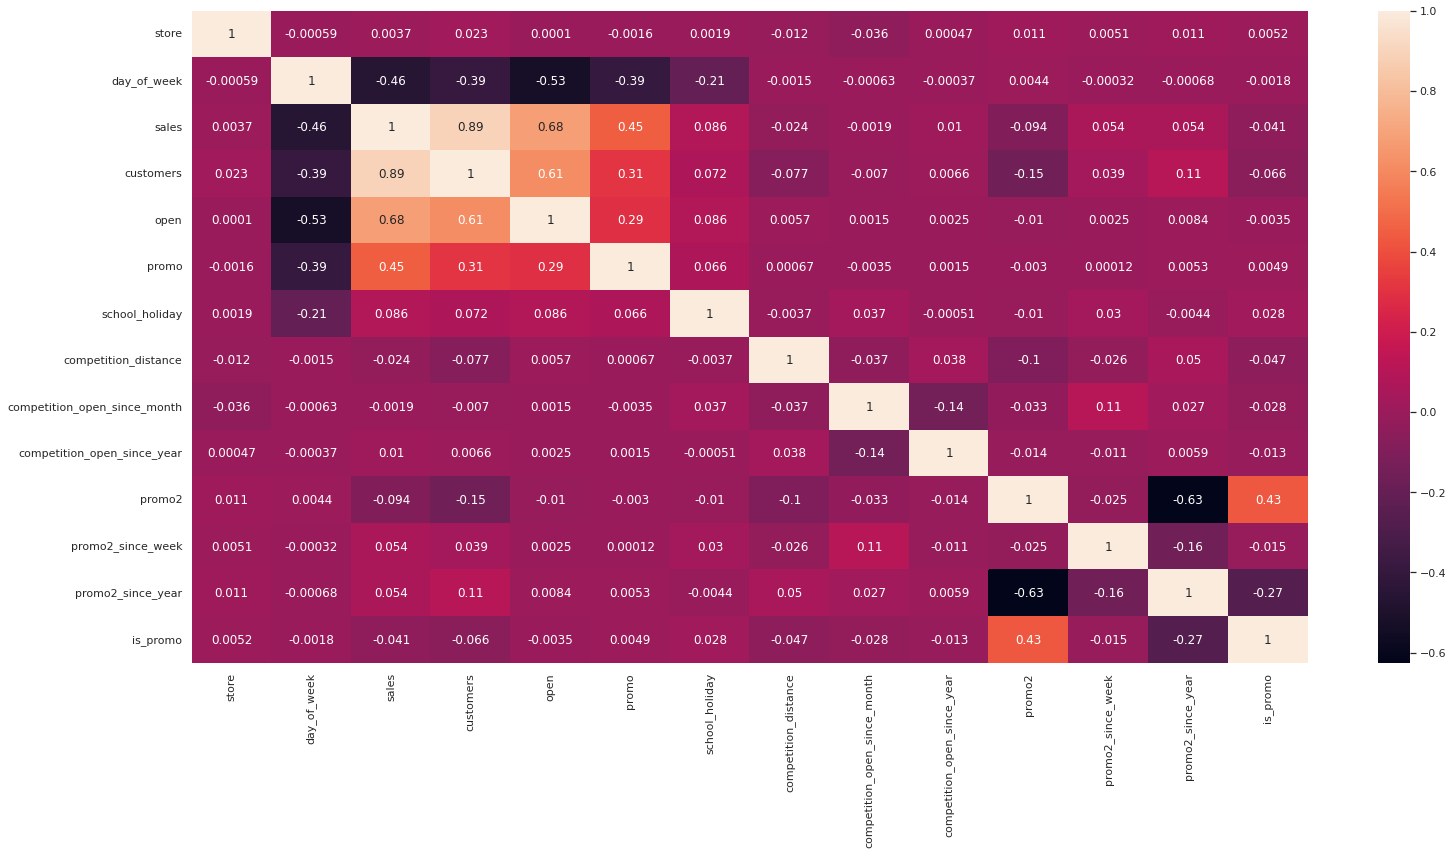

In [41]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

#### Categorical Attributes

In [42]:
!pip install researchpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import researchpy

In [44]:
def cramer_v( x, y ):
  cm, res = researchpy.crosstab(x, y , test = 'chi-square')
  teste = res['results'][2]
  return teste

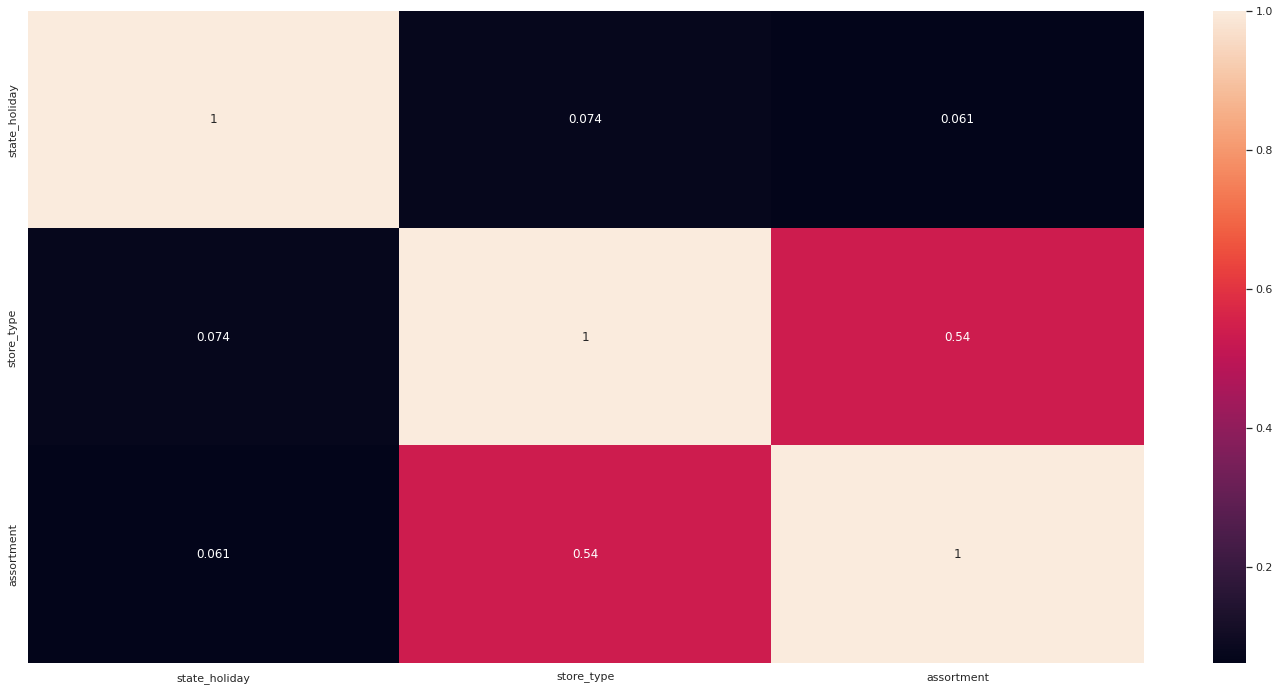

In [45]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

###4.4 Insights


Alguns insights são interessantes sobre a relação das variáveis com a variável resposta sales:

1. Mais vendas quando se tem competição por perto, com correlação considerável
2. Ano tem correlação muito alta com as vendas, apesar de termos apenas 3 observações
3. Meses têm relações altas com vendas, sendo os primeiros meses do ano um período de altas vendas
4. alta correlação com o dia da semana, sendo os primeiros dias melhores para vendas e domingo normalmente fica fechado


Outras relações multivariadas:

1. Tipo de sortimento relacionado com tipo de loja
2. Loja aberta, promoção e clientes e dia da semana tem relação entre si




## 5.0 Data Preparation

In [46]:
df5 = df4.copy()

###5.1 Rescaling

In [47]:
rs = RobustScaler()
mms = MinMaxScaler()
scaler = StandardScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
#pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
#pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = scaler.fit_transform( df5[['promo_time_week']].values )
#pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = scaler.fit_transform( df5[['year']].values )
#pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

In [48]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
937002,73,3,2013-03-13,4314,0,christmas,0,a,extended,-0.109855,9,2008,0,11,2013,0,-1.069562,3,13,11,2013-10,2008-09-01,0.527027,2013-03-11,-0.636417
905193,599,4,2013-04-11,8646,1,christmas,0,d,extended,-0.282714,11,2014,0,15,2013,0,-1.069562,4,11,15,2013-14,2014-11-01,-0.472973,2013-04-08,-0.636417
1000557,73,2,2013-01-15,3827,0,christmas,0,a,extended,-0.109855,9,2008,0,3,2013,0,-1.069562,1,15,3,2013-02,2008-09-01,0.500000,2013-01-14,-0.636417
268814,776,4,2014-11-27,5358,1,christmas,0,c,basic,-0.263328,4,2009,1,14,2011,0,0.217222,11,27,48,2014-47,2009-04-01,0.702703,2011-03-28,1.597365
495346,1072,1,2014-04-14,9706,1,christmas,1,a,extended,0.492730,8,2015,1,5,2010,0,0.217222,4,14,16,2014-15,2015-08-01,-0.432432,2010-01-25,1.936526


### 5.2 Transformacao

#### 5.2.1. Encoding

In [49]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
937002,73,3,2013-03-13,4314,0,christmas,0,a,extended,-0.109855,9,2008,0,11,2013,0,-1.069562,3,13,11,2013-10,2008-09-01,0.527027,2013-03-11,-0.636417
905193,599,4,2013-04-11,8646,1,christmas,0,d,extended,-0.282714,11,2014,0,15,2013,0,-1.069562,4,11,15,2013-14,2014-11-01,-0.472973,2013-04-08,-0.636417
1000557,73,2,2013-01-15,3827,0,christmas,0,a,extended,-0.109855,9,2008,0,3,2013,0,-1.069562,1,15,3,2013-02,2008-09-01,0.500000,2013-01-14,-0.636417
268814,776,4,2014-11-27,5358,1,christmas,0,c,basic,-0.263328,4,2009,1,14,2011,0,0.217222,11,27,48,2014-47,2009-04-01,0.702703,2011-03-28,1.597365
495346,1072,1,2014-04-14,9706,1,christmas,1,a,extended,0.492730,8,2015,1,5,2010,0,0.217222,4,14,16,2014-15,2015-08-01,-0.432432,2010-01-25,1.936526


In [50]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [51]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday
937002,73,3,2013-03-13,4314,0,0,0,3,-0.109855,9,2008,0,11,2013,0,-1.069562,3,13,11,2013-10,2008-09-01,0.527027,2013-03-11,-0.636417,1,0,0
905193,599,4,2013-04-11,8646,1,0,3,3,-0.282714,11,2014,0,15,2013,0,-1.069562,4,11,15,2013-14,2014-11-01,-0.472973,2013-04-08,-0.636417,1,0,0
1000557,73,2,2013-01-15,3827,0,0,0,3,-0.109855,9,2008,0,3,2013,0,-1.069562,1,15,3,2013-02,2008-09-01,0.500000,2013-01-14,-0.636417,1,0,0
268814,776,4,2014-11-27,5358,1,0,2,1,-0.263328,4,2009,1,14,2011,0,0.217222,11,27,48,2014-47,2009-04-01,0.702703,2011-03-28,1.597365,1,0,0
495346,1072,1,2014-04-14,9706,1,1,0,3,0.492730,8,2015,1,5,2010,0,0.217222,4,14,16,2014-15,2015-08-01,-0.432432,2010-01-25,1.936526,1,0,0


#### 5.2.2. Response Variable Transformation

In [52]:
df5['sales'] = np.log1p( df5['sales'] )

#### 5.3.3. Nature Transformation

In [53]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [54]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
937002,73,3,2013-03-13,8.369853,0,0,0,3,-0.109855,9,2008,0,11,2013,0,-1.069562,3,13,11,2013-10,2008-09-01,0.527027,2013-03-11,-0.636417,1,0,0,0.433884,-0.900969,1.000000,6.123234e-17,4.067366e-01,-0.913545,0.970942,0.239316
905193,599,4,2013-04-11,9.064968,1,0,3,3,-0.282714,11,2014,0,15,2013,0,-1.069562,4,11,15,2013-14,2014-11-01,-0.472973,2013-04-08,-0.636417,1,0,0,-0.433884,-0.900969,0.866025,-5.000000e-01,7.431448e-01,-0.669131,0.970942,-0.239316
1000557,73,2,2013-01-15,8.250098,0,0,0,3,-0.109855,9,2008,0,3,2013,0,-1.069562,1,15,3,2013-02,2008-09-01,0.500000,2013-01-14,-0.636417,1,0,0,0.974928,-0.222521,0.500000,8.660254e-01,1.224647e-16,-1.000000,0.354605,0.935016
268814,776,4,2014-11-27,8.586533,1,0,2,1,-0.263328,4,2009,1,14,2011,0,0.217222,11,27,48,2014-47,2009-04-01,0.702703,2011-03-28,1.597365,1,0,0,-0.433884,-0.900969,-0.500000,8.660254e-01,-5.877853e-01,0.809017,-0.464723,0.885456
495346,1072,1,2014-04-14,9.180603,1,1,0,3,0.492730,8,2015,1,5,2010,0,0.217222,4,14,16,2014-15,2015-08-01,-0.432432,2010-01-25,1.936526,1,0,0,0.781831,0.623490,0.866025,-5.000000e-01,2.079117e-01,-0.978148,0.935016,-0.354605


##6.0 Feature Selection

In [55]:
df6 = df5.copy()

In [56]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
937002,73,3,2013-03-13,8.369853,0,0,0,3,-0.109855,9,2008,0,11,2013,0,-1.069562,3,13,11,2013-10,2008-09-01,0.527027,2013-03-11,-0.636417,1,0,0,0.433884,-0.900969,1.000000,6.123234e-17,4.067366e-01,-0.913545,0.970942,0.239316
905193,599,4,2013-04-11,9.064968,1,0,3,3,-0.282714,11,2014,0,15,2013,0,-1.069562,4,11,15,2013-14,2014-11-01,-0.472973,2013-04-08,-0.636417,1,0,0,-0.433884,-0.900969,0.866025,-5.000000e-01,7.431448e-01,-0.669131,0.970942,-0.239316
1000557,73,2,2013-01-15,8.250098,0,0,0,3,-0.109855,9,2008,0,3,2013,0,-1.069562,1,15,3,2013-02,2008-09-01,0.500000,2013-01-14,-0.636417,1,0,0,0.974928,-0.222521,0.500000,8.660254e-01,1.224647e-16,-1.000000,0.354605,0.935016
268814,776,4,2014-11-27,8.586533,1,0,2,1,-0.263328,4,2009,1,14,2011,0,0.217222,11,27,48,2014-47,2009-04-01,0.702703,2011-03-28,1.597365,1,0,0,-0.433884,-0.900969,-0.500000,8.660254e-01,-5.877853e-01,0.809017,-0.464723,0.885456
495346,1072,1,2014-04-14,9.180603,1,1,0,3,0.492730,8,2015,1,5,2010,0,0.217222,4,14,16,2014-15,2015-08-01,-0.432432,2010-01-25,1.936526,1,0,0,0.781831,0.623490,0.866025,-5.000000e-01,2.079117e-01,-0.978148,0.935016,-0.354605


### 6.1. Split dataframe into training and test dataset

In [57]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [58]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.2. Boruta as Feature Selector

In [59]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

#### 6.2.1. Best Features from Boruta

In [60]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

### 6.3. Manual Feature Selection

In [61]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [62]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
937002,73,2013-03-13,8.369853,0,0,0,3,-0.109855,9,2008,0,11,2013,0,-1.069562,0.527027,-0.636417,1,0,0,0.433884,-0.900969,1.000000,6.123234e-17,4.067366e-01,-0.913545,0.970942,0.239316
905193,599,2013-04-11,9.064968,1,0,3,3,-0.282714,11,2014,0,15,2013,0,-1.069562,-0.472973,-0.636417,1,0,0,-0.433884,-0.900969,0.866025,-5.000000e-01,7.431448e-01,-0.669131,0.970942,-0.239316
1000557,73,2013-01-15,8.250098,0,0,0,3,-0.109855,9,2008,0,3,2013,0,-1.069562,0.500000,-0.636417,1,0,0,0.974928,-0.222521,0.500000,8.660254e-01,1.224647e-16,-1.000000,0.354605,0.935016
268814,776,2014-11-27,8.586533,1,0,2,1,-0.263328,4,2009,1,14,2011,0,0.217222,0.702703,1.597365,1,0,0,-0.433884,-0.900969,-0.500000,8.660254e-01,-5.877853e-01,0.809017,-0.464723,0.885456
495346,1072,2014-04-14,9.180603,1,1,0,3,0.492730,8,2015,1,5,2010,0,0.217222,-0.432432,1.936526,1,0,0,0.781831,0.623490,0.866025,-5.000000e-01,2.079117e-01,-0.978148,0.935016,-0.354605


## 7.0 Machine Learning Modeling

In [63]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

In [64]:
x_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
937002,73,0,0,3,-0.109855,9,2008,0,11,2013,0.527027,-0.636417,0.433884,-0.900969,1.000000,6.123234e-17,4.067366e-01,-0.913545,0.970942,0.239316
905193,599,1,3,3,-0.282714,11,2014,0,15,2013,-0.472973,-0.636417,-0.433884,-0.900969,0.866025,-5.000000e-01,7.431448e-01,-0.669131,0.970942,-0.239316
1000557,73,0,0,3,-0.109855,9,2008,0,3,2013,0.500000,-0.636417,0.974928,-0.222521,0.500000,8.660254e-01,1.224647e-16,-1.000000,0.354605,0.935016
268814,776,1,2,1,-0.263328,4,2009,1,14,2011,0.702703,1.597365,-0.433884,-0.900969,-0.500000,8.660254e-01,-5.877853e-01,0.809017,-0.464723,0.885456
495346,1072,1,0,3,0.492730,8,2015,1,5,2010,-0.432432,1.936526,0.781831,0.623490,0.866025,-5.000000e-01,2.079117e-01,-0.978148,0.935016,-0.354605


### 7.1. Average Model

In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1297.458078,0.43977,1779.825103


### 7.2. Linear Regression Model

In [66]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1876.659426,0.289867,2729.814727


#### 7.2.1. Linear Regression Model - Cross Validation

In [67]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.97 +/- 304.24,0.3 +/- 0.02,2958.14 +/- 482.13


### 7.3. Linear Regression Regularized Model - Lasso

In [68]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1903.057083,0.286885,2804.510591


#### 7.3.1. Lasso - Cross Validation

In [69]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2115.21 +/- 347.55,0.29 +/- 0.01,3058.64 +/- 515.26


### 7.4. Random Forest Regressor


In [70]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,761.683144,0.11181,1148.326612


#### 7.4.1. Random Forest Regressor - Cross Validation


In [71]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv
# 12 min com .25 sample


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,945.82 +/- 317.1,0.13 +/- 0.03,1423.02 +/- 478.31


### 7.5. XGBoost Regressor


In [72]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,921.72815,0.132052,1384.252958


#### 7.5.1. XGBoost Regressor - Cross Validation


In [73]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv
#5 min com .25 sample


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1047.61 +/- 161.62,0.15 +/- 0.02,1515.82 +/- 222.98


### 7.6. Compare Model's Performance


#### 7.6.1. Single Performance


In [74]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,761.683144,0.111810,1148.326612
0,XGBoost Regressor,921.728150,0.132052,1384.252958
0,Average Model,1297.458078,0.439770,1779.825103
0,Linear Regression,1876.659426,0.289867,2729.814727
0,Linear Regression - Lasso,1903.057083,0.286885,2804.510591


#### 7.6.2. Real Performance - Cross Validation

In [75]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.97 +/- 304.24,0.3 +/- 0.02,2958.14 +/- 482.13
0,Lasso,2115.21 +/- 347.55,0.29 +/- 0.01,3058.64 +/- 515.26
0,Random Forest Regressor,945.82 +/- 317.1,0.13 +/- 0.03,1423.02 +/- 478.31
0,XGBoost Regressor,1047.61 +/- 161.62,0.15 +/- 0.02,1515.82 +/- 222.98


## 8.0. Fine Tuning


## 8.1. Random Search

In [75]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [75]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [75]:
#final_result

### 8.2. Final Model

In [80]:
param_tuned = {
    'n_estimators': 1000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [81]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,766.95915,0.113346,1138.991112


In [82]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.010800249955544293

## 9.0 Performance Evaluation

In [83]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

### 9.1 Business Performance

In [84]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [85]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,38901.750000,26045.542725,51757.957275,12856.207275,0.949342
781,782,49830.074219,48613.231825,51046.916612,1216.842394,0.524546
169,170,28287.347656,26669.877930,29904.817383,1617.469727,0.407291
594,595,89662.796875,84090.329590,95235.264160,5572.467285,0.352361
291,292,28358.199219,24615.079834,32101.318604,3743.119385,0.325723


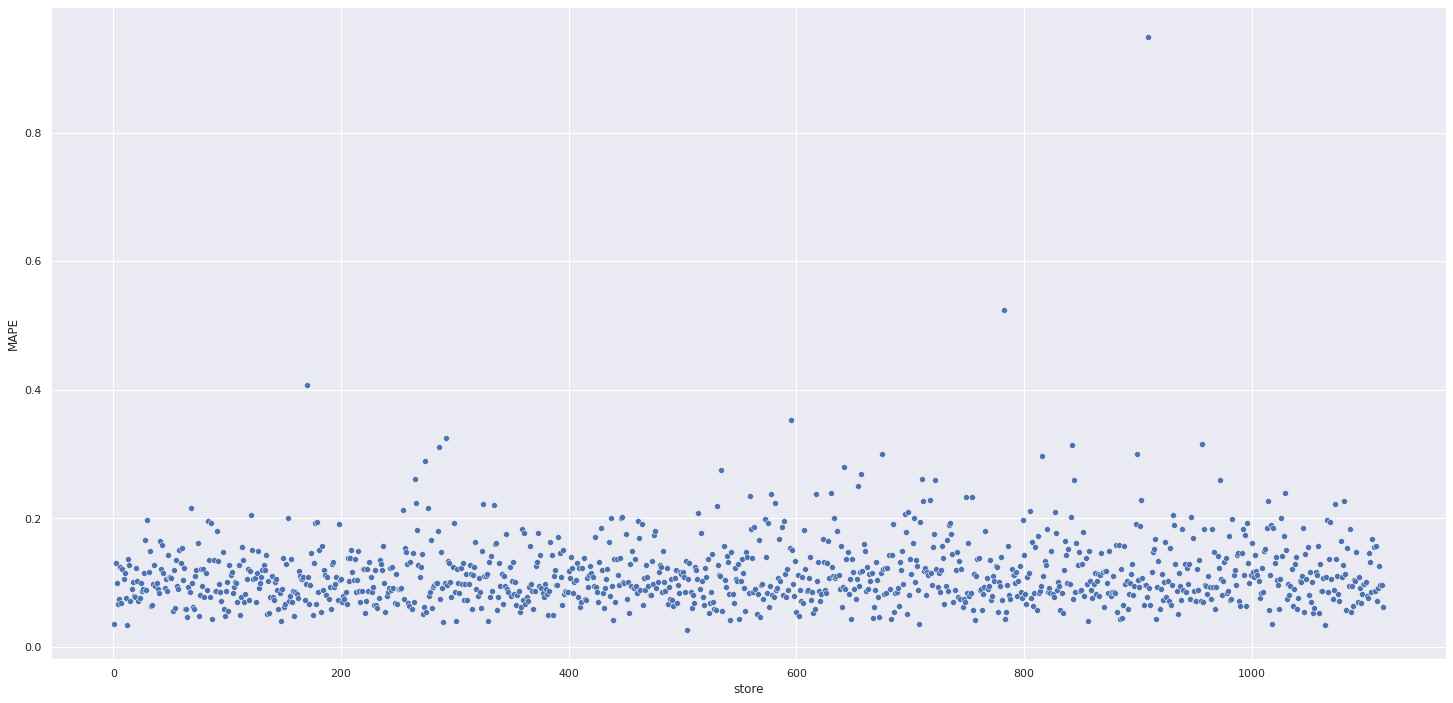

In [86]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

### 9.2. Total Performance

In [87]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$71,946,240.00"
1,worst_scenario,"R$71,093,536.13"
2,best_scenario,"R$72,798,926.88"


### 9.3. Machine Learning Performance

In [88]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

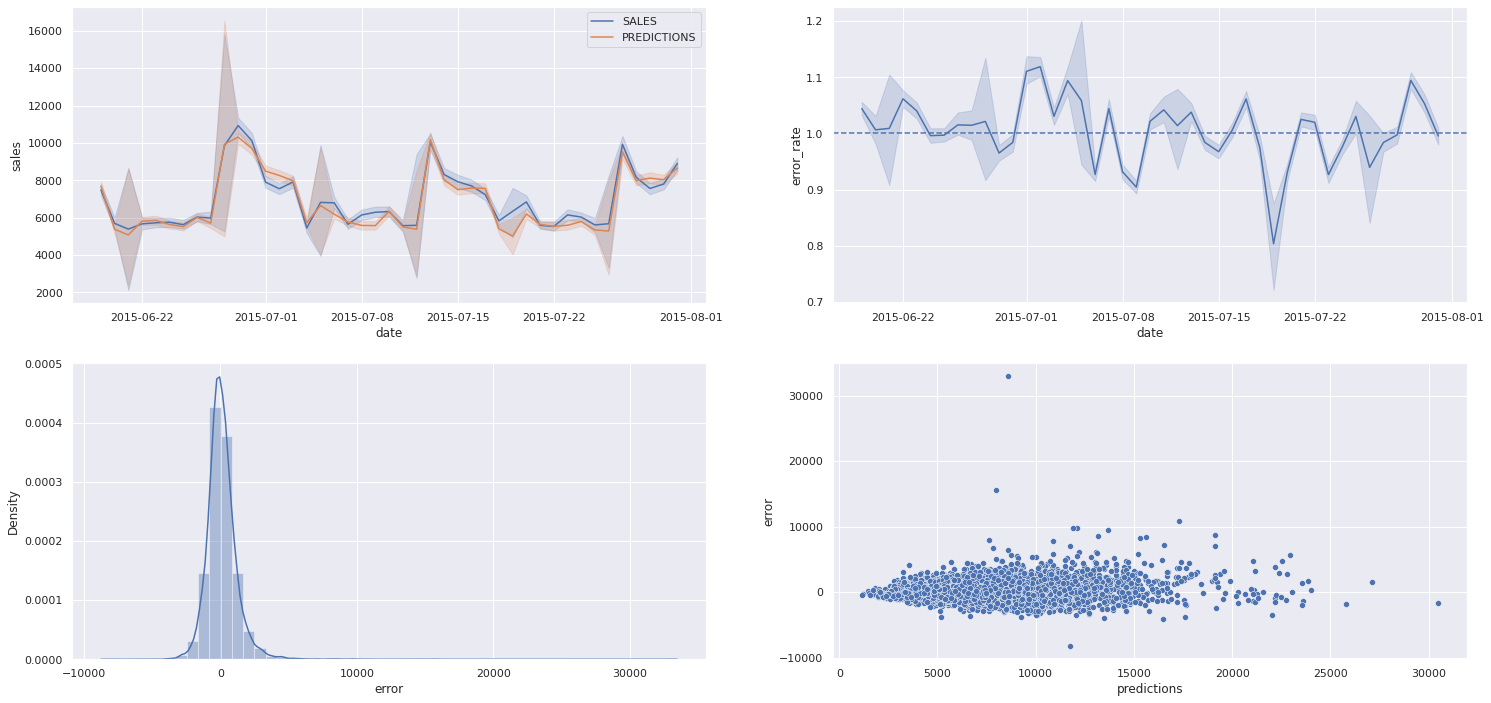

In [89]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

### 9.4 Conclusions




1. Apesar de algumas lojas possuírem erros consideráveis, quase todas apresentam erro abaixo de 20% (MAPE) nas previsões.
2. Os cenários criados possibilitam a tomada de decisão de forma mais resposnável: é recomendável o investimento na estrutura de tele-entrega, já que a receita segue com relativa previsibilidade, supondo que nada de atípico acontecerá.
3. Nosso modelo é 4x melhor para prever a receita do que o modelo atualmente usado pela loja (média).